## Background
Previously, I modeled a "heat box", but ignored the effects of the sun. As anyone who has had to get into a car that has sat outside for a while on a hot summer day, the inside of the car is warmer than the outside air temperature, and my previous model didn't allow that. So the sun is important.  Consider the following information from [The Humane Society](https://www.humanesociety.org/resources/what-do-if-you-see-pet-parked-car).

> It doesn't have to be that warm outside for a car to become dangerously hot inside.
>
> - When it's 72 degrees Fahrenheit outside, the temperature inside your car can heat up to 116 degrees Fahrenheit within an hour.
> - When it's 80 degrees Fahrenheit outside, the temperature inside your car can heat up to 99 degrees Fahrenheit within 10 minutes.
> - Rolling down the windows has been shown to have little effect on the temperature inside a car.

Let's translate these temperatures to Celsius and Kelvin

- When it's 22 degrees Celsius (295 K) outside, the temperature inside your car can heat up to 47 degrees Celsius (320 K) within an hour.
- When it's 27 degrees Celsius (300 K) outside, the temperature inside your car can heat up to 37 degrees Celsius (310 K) within 10 minutes.

My plan for this post is to assume that my heat box will heat up similarly to the above generic car, and see what sort of parameters I need to make that work.

## Previous work
As before, I'll model the system as a simple box, utilizing the same thermal properties for the material.  

In [1]:
import numpy as np

# Heat parameters
thermalDiffusivity = 22.39e-6 # meters^2/s for air
heatTransferCoef = 1 # For a typical metal to air
thermalConductivity = 50 # For a typical metal
specificHeat = 1000 # for aluminum
wallDensity = 3000 # kg/m^3 for aluminum
wallThickness = 0.002 # m
solarIntensity = 1000 # W/m^2

# Length parameters (meters)
L = 2
W = 1
H = 1

Deltax = 0.05
xmax = int(L/Deltax)
ymax = int(W/Deltax)
zmax = int(H/Deltax)

xmid = xmax // 2
ymid = ymax // 2
zmid = zmax // 2

xgrid = np.linspace(0,L,xmax+1)
ygrid = np.linspace(0,W,ymax+1)
zgrid = np.linspace(0,H,zmax+1)

u0 = np.empty((xmax,ymax,zmax))

## Heat Equation
The heat equation is:

$$
\frac{\partial u}{\partial t} = \alpha \nabla^2u + f
$$

where $u = u(x,y,z,t)$ is a function that describes the temperature in a system, $\alpha$ is the thermal diffusivity, and $f = f(x,y,z,t)$ is a function describing internal heat generation in a material:

$$
f(x,y,z,t) = \frac{P(x,y,z,t)}{c\rho}
$$

where $c$ is the specific heat of the material, $\rho$ is the density of the material, and $P(x,y,z,t)$ describes the power generation per unit volume in the material. 

### Finite element analysis
In my previous post, I broke down the temperature function as follows:
$$
u(x,y,z,t) \rightarrow u(x_i,y_j,z_k,t_l) = u^l_{ijk}
$$

Rather making the system discrete in space **and** time, I will make the system discrete in space only:
$$
u(x,y,z,t) \rightarrow u(x_i,y_j,z_k,t) = u_{ijk}(t)
$$

The Laplacian using the finite element analysis is:

\begin{align*}
\nabla^2 u(x,y,z,t) &\rightarrow \frac{1}{\Delta x\Delta y\Delta z} \left(\Delta y \Delta z \frac{u_{i-1,j,k}(t) + u_{i+1,j,k}(t) - 2 u_{i,j,k}(t)}{\Delta x} 
            + \Delta x \Delta z \frac{u_{i,j-1,k}(t) + u_{i,j+1,k}(t) - 2 u_{i,j,k}(t)}{\Delta y} 
            + \Delta x \Delta y \frac{u_{i,j,k-1}(t) + u_{i,j,k+1}(t) - 2 u_{i,j,k}(t)}{\Delta z}\right) \\
            &= \frac{u_{i-1,j,k}(t) + u_{i+1,j,k}(t) - 2 u_{i,j,k}(t)}{\Delta x^2} 
            + \frac{u_{i,j-1,k}(t) + u_{i,j+1,k}(t) - 2 u_{i,j,k}(t)}{\Delta y^2} 
            + \frac{u_{i,j,k-1}(t) + u_{i,j,k+1}(t) - 2 u_{i,j,k}(t)}{\Delta z^2}
\end{align*}

If we generate our grid with $\Delta x = \Delta y = \Delta z$, we obtain:

$$
\nabla^2 u_{i,j,k}(t) = \frac{u_{i-1,j,k}(t) + u_{i+1,j,k}(t) + u_{i,j-1,k}(t) + u_{i,j+1,k}(t) + u_{i,j,k-1}(t) + u_{i,j,k+1}(t) - 6 u_{i,j,k}(t)}{\Delta x^2}
$$

### Incorporating boundary conditions
Essentially, the heat equation is a statement of energy density flow within a system. 
$$
\frac{du_{ijk}(t)}{\partial t} = \alpha \nabla^2 u_{ijk}(t) + f_{ijk}(t) + \frac{\text{Boundary power exchanged per unit volume}}{c\rho}
$$
where the third term is non-zero only on the boundary.

#### Heat Equation on a boundary *surface*
So if we are considering the $x=0, i=0$ surface:
$$
\frac{du_{0,j,k}(t)}{\partial t} = \alpha \nabla^2 u_{0,j,k}(t) + f_{0jk}(t) + \frac{h}{c\rho}(T_{\text{air}}-u_{0,j,k})
$$
where

\begin{align*}
\nabla^2 u_{0,j,k}(t) &= \frac{1}{\Delta x\Delta y\Delta z} \left(\Delta y \Delta z \frac{u_{1,j,k}(t) - u_{1,j,k}(t)}{\Delta x} 
            + \frac{\Delta x}{2} \Delta z \frac{u_{0,j-1,k}(t) + u_{0,j+1,k}(t) - 2 u_{0,j,k}(t)}{\Delta y} 
            + \frac{\Delta x}{2} \Delta y \frac{u_{0,j,k-1}(t) + u_{0,j,k+1}(t) - 2 u_{0,j,k}(t)}{\Delta z}\right) \\
    &= \frac{1}{2} \left(\frac{2 u_{1,j,k}(t) - 2 u_{1,j,k}(t)}{\Delta x^2} 
            + \frac{u_{0,j-1,k}(t) + u_{0,j+1,k}(t) - 2 u_{0,j,k}(t)}{\Delta y^2} 
            + \frac{u_{0,j,k-1}(t) + u_{0,j,k+1}(t) - 2 u_{0,j,k}(t)}{\Delta z^2}\right) \\
\end{align*}

Again, with a uniform grid, this becomes:
$$
\nabla^2 u_{0,j,k}(t) = \frac{2 u_{1,j,k}(t) + u_{0,j-1,k}(t) + u_{0,j+1,k}(t) + u_{0,j,k-1}(t) + u_{0,j,k+1}(t) - 6 u_{0,j,k}(t)}{2 \Delta x^2}
$$

Following a similar method we can find for all 6 surfaces:

\begin{align*}
\nabla^2 u_{0,j,k}(t) &= \frac{2 u_{1,j,k}(t) + u_{0,j-1,k}(t) + u_{0,j+1,k}(t) + u_{0,j,k-1}(t) + u_{0,j,k+1}(t) - 6 u_{0,j,k}(t)}{2 \Delta x^2} \\
\nabla^2 u_{I,j,k}(t) &= \frac{2 u_{I-1,j,k}(t) + u_{I,j-1,k}(t) + u_{I,j+1,k}(t) + u_{I,j,k-1}(t) + u_{I,j,k+1}(t) - 6 u_{I,j,k}(t)}{2 \Delta x^2} \\
\nabla^2 u_{i,0,k}(t) &= \frac{2 u_{i,1,k}(t) + u_{i-1,0,k}(t) + u_{i+1,0,k}(t) + u_{i,0,k-1}(t) + u_{i,0,k+1}(t) - 6 u_{i,0,k}(t)}{2 \Delta x^2} \\
\nabla^2 u_{i,J,k}(t) &= \frac{2 u_{i,J-1,k}(t) + u_{i-1,J,k}(t) + u_{i+1,J,k}(t) + u_{i,J,k-1}(t) + u_{i,J,k+1}(t) - 6 u_{i,J,k}(t)}{2 \Delta x^2} \\
\nabla^2 u_{i,j,0}(t) &= \frac{2 u_{i,j,1}(t) + u_{i-1,j,0}(t) + u_{i+1,j,0}(t) + u_{i,j-1,0}(t) + u_{i,j+1,0}(t) - 6 u_{i,j,0}(t)}{2 \Delta x^2} \\
\nabla^2 u_{i,j,K}(t) &= \frac{2 u_{i,j,K-1}(t) + u_{i,j-1,K}(t) + u_{i,j+1,K}(t) + u_{i,j,K}(t) + u_{i,j,k+1}(t) - 6 u_{i,j,K}(t)}{2 \Delta x^2} \\
\end{align*}

#### Heat equation on a boundary *edge*
So if we are considering the $x=0, i=0$, $y=0, j=0$ edge:
$$
\frac{du_{0,0,k}(t)}{\partial t} = \alpha \nabla^2 u_{0,0,k}(t) + f_{0,0,k}(t) + \frac{h}{c\rho}(T_{\text{air}}-u_{0,0,k})
$$
where

\begin{align*}
\nabla^2 u_{0,0,k}(t) &= \frac{1}{\Delta x\Delta y\Delta z} \left(\frac{\Delta y}{2} \Delta z \frac{u_{1,0,k}(t) - u_{0,0,k}(t)}{\Delta x} 
            + \frac{\Delta x}{2} \Delta z \frac{u_{0,1,k}(t) - u_{0,0,k}(t)}{\Delta y} 
            + \frac{\Delta x}{2} \frac{\Delta y}{2} \frac{u_{0,0,k-1}(t) + u_{0,0,k+1}(t) - 2 u_{0,0,k}(t)}{\Delta z}\right) \\
    &= \frac{1}{4} \left(\frac{2u_{1,0,k}(t) - 2u_{0,0,k}(t)}{\Delta x^2} 
            + \frac{2u_{0,1,k}(t) - 2u_{0,0,k}(t)}{\Delta y^2} 
            + \frac{u_{0,0,k-1}(t) + u_{0,0,k+1}(t) - 2 u_{0,0,k}(t)}{\Delta z^2}\right) \\
\end{align*}

Again, with a uniform grid, this becomes:
$$
\nabla^2 u_{0,0,k}(t) = \frac{2 u_{1,0,k}(t) +  2 u_{0,1,k}(t) + u_{0,0,k-1}(t) + u_{0,0,k+1}(t) - 6 u_{0,0,k}(t)}{4 \Delta x^2}
$$

Following a similar method we can find for all 12 edges:

\begin{align*}
    \nabla^2 u_{0,0,k}(t) &= \frac{2 u_{1,0,k}(t) +  2 u_{0,1,k}(t) + u_{0,0,k-1}(t) + u_{0,0,k+1}(t) - 6 u_{0,0,k}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{0,J,k}(t) &= \frac{2 u_{1,J,k}(t) +  2 u_{0,J-1,k}(t) + u_{0,J,k-1}(t) + u_{0,J,k+1}(t) - 6 u_{0,J,k}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{0,j,0}(t) &= \frac{2 u_{1,j,0}(t) +  2 u_{0,j,1}(t) + u_{0,j-1,0}(t) + u_{0,j+1,0}(t) - 6 u_{0,j,0}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{0,j,K}(t) &= \frac{2 u_{1,j,K}(t) +  2 u_{0,j,K-1}(t) + u_{0,j-1,K}(t) + u_{0,j+1,0}(t) - 6 u_{0,j,K}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{I,0,k}(t) &= \frac{2 u_{I-1,0,k}(t) +  2 u_{I,1,k}(t) + u_{I,0,k-1}(t) + u_{I,0,k+1}(t) - 6 u_{I,0,k}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{I,J,k}(t) &= \frac{2 u_{I-1,J,k}(t) +  2 u_{I,J-1,k}(t) + u_{I,J,k-1}(t) + u_{I,J,k+1}(t) - 6 u_{I,J,k}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{I,j,0}(t) &= \frac{2 u_{I-1,j,0}(t) +  2 u_{I,j,1}(t) + u_{I,j-1,0}(t) + u_{I,j+1,0}(t) - 6 u_{I,j,0}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{I,j,K}(t) &= \frac{2 u_{I-1,j,K}(t) +  2 u_{I,j,K-1}(t) + u_{I,j-1,K}(t) + u_{I,j+1,K}(t) - 6 u_{I,j,K}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{i,0,0}(t) &= \frac{2 u_{i,0,1}(t) +  2 u_{i,1,0}(t) + u_{i-1,0,0}(t) + u_{i+1,0,0}(t) - 6 u_{i,0,0}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{i,0,K}(t) &= \frac{2 u_{i,0,K-1}(t) +  2 u_{i,1,K}(t) + u_{i-1,0,K}(t) + u_{i+1,0,K}(t) - 6 u_{i,0,K}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{i,J,0}(t) &= \frac{2 u_{i,J,1}(t) +  2 u_{i,J-1,0}(t) + u_{i-1,J,0}(t) + u_{i+1,J,0}(t) - 6 u_{i,J,0}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{i,J,K}(t) &= \frac{2 u_{i,J,K-1}(t) +  2 u_{i,J-1,K}(t) + u_{i-1,J,K}(t) + u_{i+1,J,K}(t) - 6 u_{i,J,K}(t)}{4 \Delta x^2} \\
\end{align*}

#### Heat equation on a boundary *corner*
So if we are considering the $x=0, i=0$, $y=0, j=0$, $z=0, k=0$ corner:
$$
\frac{du_{0,0,0}(t)}{\partial t} = \alpha \nabla^2 u_{0,0,0}(t) + f_{0,0,0}(t) + \frac{h}{c\rho}(T_{\text{air}}-u_{0,0,0})
$$
where

\begin{align*}
\nabla^2 u_{0,0,0}(t) &= \frac{1}{\Delta x\Delta y\Delta z} \left(\frac{\Delta y}{2} \frac{\Delta z}{2} \frac{u_{1,0,0}(t) - u_{0,0,0}(t)}{\Delta x} 
            + \frac{\Delta x}{2} \frac{\Delta z}{2} \frac{u_{0,1,0}(t) - u_{0,0,0}(t)}{\Delta y} 
            + \frac{\Delta x}{2} \frac{\Delta y}{2} \frac{u_{0,0,1}(t) - 2 u_{0,0,0}(t)}{\Delta z}\right) \\
    &= \frac{1}{4} \left(\frac{2u_{1,0,0}(t) - 2u_{0,0,0}(t)}{\Delta x^2} 
            + \frac{2u_{0,1,0}(t) - 2u_{0,0,0}(t)}{\Delta y^2} 
            + \frac{2u_{0,0,1}(t) - 2 u_{0,0,0}(t)}{\Delta z^2}\right) \\
\end{align*}

Again, with a uniform grid, this becomes:
$$
\nabla^2 u_{0,0,0}(t) = \frac{u_{1,0,0}(t) +  u_{0,1,0}(t) + u_{0,0,1}(t) - 3 u_{0,0,0}(t)}{2 \Delta x^2}
$$

Following a similar method we can find for all 8 corners:

\begin{align*}
    \nabla^2 u_{0,0,0}(t) &= \frac{u_{1,0,0}(t) +  u_{0,1,0}(t) + u_{0,0,1}(t) - 3 u_{0,0,0}(t)}{2 \Delta x^2} \\
    \nabla^2 u_{I,0,0}(t) &= \frac{u_{I-1,0,0}(t) +  u_{I,1,0}(t) + u_{I,0,1}(t) - 3 u_{I,0,0}(t)}{2 \Delta x^2} \\
    \nabla^2 u_{0,J,0}(t) &= \frac{u_{1,J,0}(t) +  u_{0,J-1,0}(t) + u_{0,J,1}(t) - 3 u_{0,J,0}(t)}{2 \Delta x^2} \\
    \nabla^2 u_{0,0,K}(t) &= \frac{u_{1,0,K}(t) +  u_{0,1,K}(t) + u_{0,0,K-1}(t) - 3 u_{0,0,K}(t)}{2 \Delta x^2} \\
    \nabla^2 u_{I,J,0}(t) &= \frac{u_{I-1,J,0}(t) +  u_{I,J-1,0}(t) + u_{I,J,1}(t) - 3 u_{I,J,0}(t)}{2 \Delta x^2} \\
    \nabla^2 u_{I,0,K}(t) &= \frac{u_{I-1,0,K}(t) +  u_{I,1,K}(t) + u_{I,0,K-1}(t) - 3 u_{I,0,K}(t)}{2 \Delta x^2} \\
    \nabla^2 u_{0,J,K}(t) &= \frac{u_{1,J,K}(t) +  u_{0,J-1,K}(t) + u_{0,J,K-1}(t) - 3 u_{0,J,K}(t)}{2 \Delta x^2} \\
    \nabla^2 u_{I,J,K}(t) &= \frac{u_{I-1,J,K}(t) +  u_{I,J-1,K}(t) + u_{I,J,K-1}(t) - 3 u_{I,J,K}(t)}{2 \Delta x^2} \\
\end{align*}

In [2]:
def lap3DFE(umat,dx):
    lap = np.empty_like(umat)

    # Interior elements:
    lap[1:-1,1:-1,1:-1] = (umat[:-2, 1:-1, 1:-1] + umat[2:, 1:-1, 1:-1] + umat[1:-1, :-2, 1:-1] + 
                           umat[1:-1, 2:, 1:-1] + umat[1:-1,1:-1,:-2] + umat[1:-1,1:-1,2:] - 6*umat[1:-1,1:-1,1:-1]) / dx**2

    # Surface elements:
    lap[0,1:-1,1:-1] = (2* umat[1, 1:-1, 1:-1] + 
                        umat[0, :-2, 1:-1] + umat[0, 2:, 1:-1] + umat[0, 1:-1, :-2] + umat[0, 1:-1, 2:] - 6*umat[0, 1:-1, 1:-1]) / (2*dx**2)
    lap[-1,1:-1,1:-1] = (2* umat[-2, 1:-1, 1:-1] + 
                        umat[-1, :-2, 1:-1] + umat[-1, 2:, 1:-1] + umat[-1, 1:-1, :-2] + umat[-1, 1:-1, 2:] - 6*umat[-1, 1:-1, 1:-1]) / (2*dx**2)
    lap[1:-1,0,1:-1] = (2* umat[1:-1, 1, 1:-1] + 
                        umat[:-2, 0, 1:-1] + umat[2:, 0, 1:-1] + umat[1:-1, 0, :-2] + umat[1:-1, 0, 2:] - 6*umat[1:-1, 0, 1:-1]) / (2*dx**2)
    lap[1:-1,-1,1:-1] = (2* umat[1:-1, -2, 1:-1] + 
                        umat[:-2, -1, 1:-1] + umat[2:, -1, 1:-1] + umat[1:-1, -1, :-2] + umat[1:-1, -1, 2:] - 6*umat[1:-1, -1, 1:-1]) / (2*dx**2)
    lap[1:-1,1:-1,0] = (2* umat[1:-1, 1:-1, 1] + 
                        umat[:-2, 1:-1, 0] + umat[2:, 1:-1, 0] + umat[1:-1, :-2, 0] + umat[1:-1, 2:, 0] - 6*umat[1:-1, 1:-1, 0]) / (2*dx**2)
    lap[1:-1,1:-1,-1] = (2* umat[1:-1, 1:-1, -2] + 
                        umat[:-2, 1:-1, -1] + umat[2:, 1:-1, -1] + umat[1:-1, :-2, -1] + umat[1:-1, 2:, -1] - 6*umat[1:-1, 1:-1, -1]) / (2*dx**2)

    # Edge Elements:
    lap[0,0,1:-1] = (2 * umat[1, 0, 1:-1] + 2 * umat[0, 1, 1:-1] + umat[0, 0, :-2] + umat[0, 0, 2:] - 6*umat[0, 0, 1:-1]) / (4*dx**2)
    lap[0,-1,1:-1] = (2 * umat[1, -1, 1:-1] + 2 * umat[0, -2, 1:-1] + umat[0, -1, :-2] + umat[0, -1, 2:] - 6*umat[0, -1, 1:-1]) / (4*dx**2)
    lap[-1,0,1:-1] = (2 * umat[2, 0, 1:-1] + 2 * umat[-1, 1, 1:-1] + umat[-1, 0, :-2] + umat[-1, 0, 2:] - 6*umat[-1, 0, 1:-1]) / (4*dx**2)
    lap[-1,-1,1:-1] = (2 * umat[2, -1, 1:-1] + 2 * umat[-1, -2, 1:-1] + umat[-1, -1, :-2] + umat[-1, -1, 2:] - 6*umat[-1, -1, 1:-1]) / (4*dx**2)
    lap[0,1:-1,0] = (2 * umat[1, 1:-1, 0] + 2 * umat[0, 1:-1, 1] + umat[0, 2:, 0] + umat[0, :-2, 0] - 6*umat[0, 1:-1, 0]) / (4*dx**2)
    lap[0,1:-1,-1] = (2 * umat[1, 1:-1, -1] + 2 * umat[0, 1:-1, -2] + umat[0, 2:, -1] + umat[0, :-2, -1] - 6*umat[0, 1:-1, -1]) / (4*dx**2)
    lap[-1,1:-1,0] = (2 * umat[-2, 1:-1, 0] + 2 * umat[-1, 1:-1, 1] + umat[-1, 2:, 0] + umat[-1, :-2, 0] - 6*umat[-1, 1:-1, 0]) / (4*dx**2)
    lap[-1,1:-1,-1] = (2 * umat[-2, 1:-1, -1] + 2 * umat[-1, 1:-1, -2] + umat[-1, 2:, -1] + umat[-1, :-2, -1] - 6*umat[-1, 1:-1, -1]) / (4*dx**2)
    lap[1:-1,0,0] = (2 * umat[1:-1, 1, 0] + 2 * umat[1:-1, 0, 1] + umat[:-2, 0, 0] + umat[2:, 0, 0] - 6*umat[1:-1, 0, 0]) / (4*dx**2)
    lap[1:-1,0,-1] = (2 * umat[1:-1, 1, -1] + 2 * umat[1:-1, 0, -2] + umat[:-2, 0, -1] + umat[2:, 0, -1] - 6*umat[1:-1, 0, -1]) / (4*dx**2)
    lap[1:-1,-1,0] = (2 * umat[1:-1, -2, 0] + 2 * umat[1:-1, -1, 1] + umat[:-2, -1, 0] + umat[2:, -1, 0] - 6*umat[1:-1, -1, 0]) / (4*dx**2)
    lap[1:-1,-1,-1] = (2 * umat[1:-1, 2, -1] + 2 * umat[1:-1, -1, -2] + umat[:-2, -1, -1] + umat[2:, -1, -1] - 6*umat[1:-1, -1, -1]) / (4*dx**2)    
    
    # Corner Elements:
    lap[0,0,0] = (umat[1, 0, 0] + umat[0, 1, 0] + umat[0, 0, 1] - 3*umat[0, 0, 0]) / (2*dx**2)
    lap[-1,0,0] = (umat[-2, 0, 0] + umat[-1, 1, 0] + umat[-1, 0, 1] - 3*umat[-1, 0, 0]) / (2*dx**2)
    lap[0,-1,0] = (umat[1, -1, 0] + umat[0, -2, 0] + umat[0, -1, 1] - 3*umat[0, -1, 0]) / (2*dx**2)
    lap[0,0,-1] = (umat[1, 0, -1] + umat[0, 1, -1] + umat[0, 0, -2] - 3*umat[0, 0, -1]) / (2*dx**2)
    lap[0,-1,-1] = (umat[1, -1, -1] + umat[0, -2, -1] + umat[0, -1, -2] - 3*umat[0, -1, -1]) / (2*dx**2)
    lap[-1,0,-1] = (umat[-2, 0, -1] + umat[-1, 1, -1] + umat[-1, 0, -2] - 3*umat[-1, 0, -1]) / (2*dx**2)
    lap[-1,-1,0] = (umat[2, -1, 0] + umat[-1, -2, 0] + umat[-1, -1, 1] - 3*umat[-1, -1, 0]) / (2*dx**2)
    lap[-1,-1,-1] = (umat[-2, -1, -1] + umat[-1, -2, -1] + umat[-1, -1, -2] - 3*umat[-1, -1, -1]) / (2*dx**2)

    return lap

### Boundary Convection

As discussed previously, the power exchange per unit volume due to convection is:

$$
\left. \frac{du}{dt}\right|_{\text{convection}} = \frac{h}{c\rho}\left(T_{\text{air}}-u(x_S,y_S,z_S,t)\right)
$$
for points $(x_S,y_S,z_S)$ on the boundary of the object (assuming a uniform air temperature).

In [3]:
def bdryConv(umat, Tair, h, c, rho, dx):
    const = h/(c*rho*dx)

    bdryTemp = np.zeros_like(umat)
    uSurf = np.zeros_like(umat)

    bdryTemp[0,:,:].fill(Tair)
    bdryTemp[:,0,:].fill(Tair)
    bdryTemp[:,:,0].fill(Tair)
    bdryTemp[-1,:,:].fill(Tair)
    bdryTemp[:,-1,:].fill(Tair)
    bdryTemp[:,:,-1].fill(Tair)

    uSurf[0,:,:] = umat[0,:,:]
    uSurf[:,0,:] = umat[:,0,:]
    uSurf[:,:,0] = umat[:,:,0]
    uSurf[-1,:,:] = umat[-1,:,:]
    uSurf[:,-1,:] = umat[:,-1,:]
    uSurf[:,:,-1] = umat[:,:,-1]

    duConvdt = const*(bdryTemp - uSurf)
    return duConvdt    

### Power generation

As described previously, power generation is described as:

$$
f(x,y,z,t) = \frac{P(x,y,z,t)}{c\rho}
$$

where $c$ is the specific heat of the material, $\rho$ is the density of the material, and $P(x,y,z,t)$ describes the power generation per unit volume in the material.  For now, I will assume that the power generation is due to direct sunlight at high noon on the equator at (either) equinox. That is, I will assume the sun is beating down on the top surface only, with direct intensity. So, for now, the power generated per unit volume is:

$$
P = \frac{I_{\text{sun}}}{D}
$$
where $I_{\text{sun}}$ is the intensity of sunlight on the surface and $D$ is the thickness of the material absorbing the sunlight.

In [4]:
def powerGen(umat, t, intensity, D, c, rho):
    powerGen = np.zeros_like(umat)

    powerDensity = intensity/(c*rho*D)
    powerGen[:,:,-1].fill(powerDensity)

    return powerGen

## Solving the heat equation numerically on a finite 3D grid
As before
$$
\frac{du_{ijk}(t)}{\partial t} = \alpha \nabla^2 u_{ijk}(t) + f_{ijk}(t) + \left. \frac{du_{ijk}}{dt}\right|_{\text{convection}}
$$
Let's put this all together in a single function.

In [5]:
def dudt(t,u, alpha, intensity, D, c, rho, h, Tair, dx):
    dudt = alpha*lap3DFE(u,dx) + powerGen(u,t,intensity, D, c, rho) + bdryConv(u, Tair, h, c, rho, dx)
    return dudt

I will have to flatten things as `solve_ivp` only solves a vector system of equations rather than the higher dimenionality matrix system that I've created.

In [6]:
def dudtFlat(t,uflat, alpha, intensity, D, c, rho, h, Tair, dx):
    u = uflat.reshape(xmax,ymax,zmax)
    return dudt(t,u, alpha, intensity, D, c, rho, h, Tair, dx).flatten()

## Calculation 1:
Attempt to recreate the following statement:

- When it's 22 degrees Celsius outside, the temperature inside your car can heat up to 47 degrees Celsius within an hour.

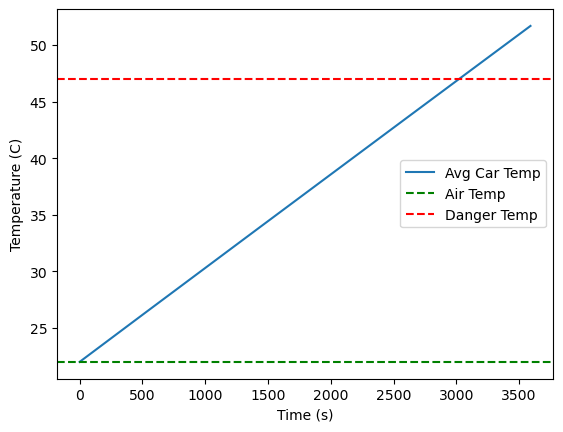

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

oneHour = 3600
airTemp = 22
hotCarTemp = 47
u0.fill(airTemp)
time = np.arange(0,oneHour,10)

oneHourCalc = solve_ivp(dudtFlat, t_span=[0,oneHour], y0=u0.flatten(), t_eval= time, 
                        args=[thermalDiffusivity,solarIntensity,wallThickness,specificHeat,wallDensity,heatTransferCoef,airTemp,Deltax])

avgBoxTempCalc1 = np.mean(oneHourCalc.y,axis=0)

plt.plot(time,avgBoxTempCalc1,label='Avg Car Temp')
plt.axhline(y=airTemp,label='Air Temp',ls='--',color='green')
plt.axhline(y=hotCarTemp,label='Danger Temp',ls='--',color='red')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

Power Generation in K/s

In [8]:
solarIntensity/(wallDensity*specificHeat*wallThickness)

0.16666666666666666

Heat transfer rate in 1/s

In [9]:
lam = heatTransferCoef/(wallDensity*specificHeat*Deltax)
print(lam)
1/lam

6.666666666666667e-06


150000.0

## Calculation 2

Recreate
- When it's 27 degrees Celsius outside, the temperature inside your car can heat up to 37 degrees Celsius within 10 minutes.

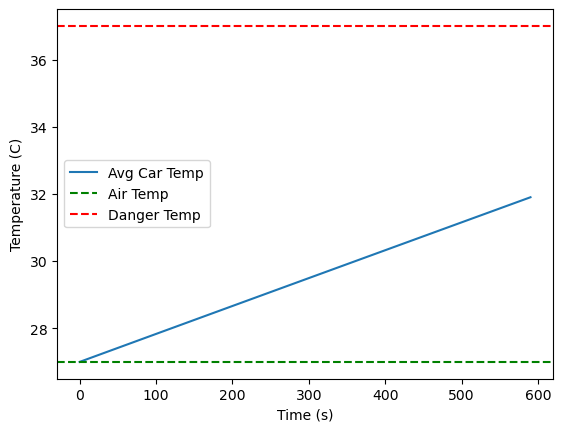

In [10]:
tenMin = 60*10
airTemp2 = 27
hotCarTemp2 = 37
u0.fill(airTemp2)
time2 = np.arange(0,tenMin,10)

tenMinCalc = solve_ivp(dudtFlat, t_span=[0,tenMin], y0=u0.flatten(), t_eval= time2, 
                        args=[thermalDiffusivity,solarIntensity,wallThickness,specificHeat,wallDensity,heatTransferCoef,airTemp2,Deltax])

avgBoxTempCalc2 = np.mean(tenMinCalc.y,axis=0)

plt.plot(time2,avgBoxTempCalc2,label='Avg Car Temp')
plt.axhline(y=airTemp2,label='Air Temp',ls='--',color='green')
plt.axhline(y=hotCarTemp2,label='Danger Temp',ls='--',color='red')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()